In [1]:
import numpy as np
from numpy import ndarray
import os
from ase.io import read, iread
from ase.neighborlist import build_neighbor_list
from ase import Atoms
from itertools import combinations_with_replacement
from tqdm import tqdm_notebook
import sys
import matplotlib.pyplot as plt
from numpy.linalg import norm
%matplotlib inline

In [2]:
def read_poscars(pfile, step=1):
    structures = []
    counter = 0
    with open(pfile, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if 'EA' in line:
                if counter % step == 0:
                    current_struct = []
                    num_of_atoms = sum([int(item) for item in lines[i+6].split()])
                    for line in lines[i:i+8+num_of_atoms+1]:
                        current_struct.append(line)
                    coef = float(current_struct[1])
                    cell = np.ndarray(shape=(3,3))
                    species = current_struct[5].split()
                    num_species = [int(item) for item in current_struct[6].split()]                    
                    symbols = np.repeat(species, num_species)
                    if 'Selective Dynamics' in current_struct:
                        raise NotImplementedError
                    positions = np.ndarray(shape=(num_of_atoms,3))
                    for j in range(3):
                        cell[j] = np.asarray(current_struct[j+2].split(), dtype=float)
                    cell *= coef
                    for n in range(num_of_atoms):
                        positions[n] = np.asarray(current_struct[n+8].split(), dtype=float)
                    if 'Direct' in current_struct[7]:
                        positions = np.dot(positions, cell)
                    ID = int(current_struct[0].split('EA')[-1])
                    structure = Atoms(symbols=symbols, positions=positions, cell=cell, pbc=True)
                    structure.ID = ID
                    structures.append(structure)
                counter += 1
    return structures

In [3]:
poscars = './POSCARS'
energies = np.loadtxt('./Energies_TOTEN', dtype=float)
structures = read_poscars(poscars)

In [9]:
Rc = 1.5
struct = structures[0]
n1 = build_neighbor_list(struct, cutoffs = len(struct.positions)*[Rc], bothways=True, self_interaction=False, skin=0.0)
iAtom = 0
indices, offsets = n1.get_neighbors(iAtom)
atomPos = struct.positions[iAtom]
neighPos = struct.positions[indices] + offsets @ struct.get_cell()
dist = np.linalg.norm(neighPos-atomPos,axis=1)
dist
# atomPos
# neighPos
# np.sort(dist)[::-1]

array([2.26365176, 2.26365176, 1.64153861, 1.8991993 , 2.66906154,
       2.66906154, 2.97959218])

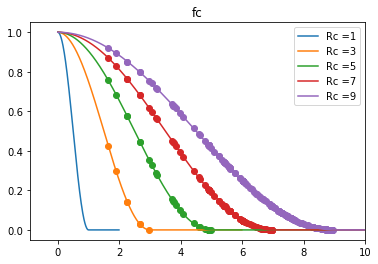

In [73]:
#For G1 
RcArray = [1, 3, 5, 7, 9]
for Rc in RcArray:
    struct = structures[0]
    n1 = build_neighbor_list(struct, cutoffs = len(struct.positions)*[Rc/2], bothways=True, self_interaction=False, skin=0.0)
    iAtom = 0
    indices, offsets = n1.get_neighbors(iAtom)
    atomPos = struct.positions[iAtom]
    neighPos = struct.positions[indices] + offsets @ struct.get_cell()
    dist = np.linalg.norm(neighPos-atomPos,axis=1)
    # fc function 
    fc = 0.5*(np.cos(np.pi*dist/(Rc))+1)
    fc[np.where(dist > Rc)] = 0
    plt.scatter(dist, fc)
    plt.title('fc')
    #test plot
    distTest = np.arange(0, 2*Rc, 0.01)
    fc = 0.5*(np.cos(np.pi*distTest/(Rc))+1)
    fc[np.where(distTest > Rc)] = 0
    plt.plot(distTest, fc, label='Rc =%i'%Rc);
plt.xlim(right=10)
plt.legend()
plt.show()

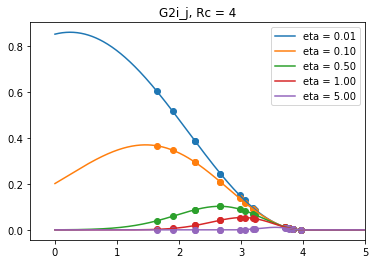

In [52]:
#For G2 
Rc = 4
EtaArray = [0.01, 0.1, 0.5, 1, 5]
for eta in EtaArray:
    struct = structures[0]
    n1 = build_neighbor_list(struct, cutoffs = len(struct.positions)*[Rc/2], bothways=True, self_interaction=False, skin=0.0)
    iAtom = 0
    indices, offsets = n1.get_neighbors(iAtom)
    atomPos = struct.positions[iAtom]
    neighPos = struct.positions[indices] + offsets @ struct.get_cell()
    dist = np.linalg.norm(neighPos-atomPos,axis=1)
    # fc function 
    fc = 0.5*(np.cos(np.pi*dist/(Rc))+1)
    fc[np.where(dist > Rc)] = 0
    G2i_j = fc*np.exp(-eta*(dist-Rc)**2)
    plt.scatter(dist, G2i_j)
    plt.title('G2i_j, Rc = %i'%Rc)
    #test plot
    distTest = np.arange(0, 2*Rc, 0.01)
    fc = 0.5*(np.cos(np.pi*distTest/(Rc))+1)
    fc[np.where(distTest > Rc)] = 0
    G2i_j = fc*np.exp(-eta*(distTest-Rc)**2)
    plt.plot(distTest, G2i_j, label='eta = %.2f'%eta)
plt.legend()
plt.xlim(right=5)
plt.show()

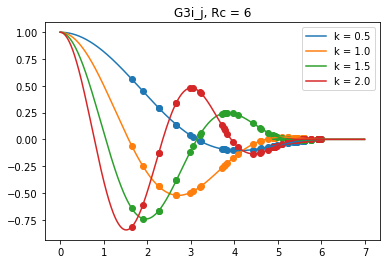

In [72]:
Rc = 6
eta = 1
KArray = [0.5, 1, 1.5, 2]
for k in KArray: 
    struct = structures[0]
    n1 = build_neighbor_list(struct, cutoffs = len(struct.positions)*[Rc/2], bothways=True, self_interaction=False, skin=0.0)
    iAtom = 0
    indices, offsets = n1.get_neighbors(iAtom)
    atomPos = struct.positions[iAtom]
    neighPos = struct.positions[indices] + offsets @ struct.get_cell()
    dist = np.linalg.norm(neighPos-atomPos,axis=1)
    # fc function 
    fc = 0.5*(np.cos(np.pi*dist/(Rc))+1)
    fc[np.where(dist > Rc)] = 0
    G3i_j = fc*np.cos(k*dist)
    plt.scatter(dist, G3i_j)
    plt.title('G3i_j, Rc = %i'%Rc)
    #test plot
    distTest = np.arange(0, Rc+1, 0.01)
    fc = 0.5*(np.cos(np.pi*distTest/(Rc))+1)
    fc[np.where(distTest > Rc)] = 0
    G3i_j = fc*np.cos(k*distTest)
    plt.plot(distTest, G3i_j, label='k = %.1f'%k)
plt.legend()
plt.show()

In [117]:
# G4, G5 
Rc = 3
zeta = 10
eta = 1
Lambda = 1 # 1 or -1, only two options

struct = structures[0]
n1 = build_neighbor_list(struct, cutoffs = len(struct.positions)*[Rc/2], bothways=True, self_interaction=False, skin=0.0)
iAtom = 0
indices, offsets = n1.get_neighbors(iAtom)
atomPos = struct.positions[iAtom]
neighPos = struct.positions[indices] + offsets @ struct.get_cell()
dist = np.linalg.norm(neighPos-atomPos,axis=1)

RDist = neighPos-atomPos
G4i = 0
G5i = 0
for j in range(len(RDist)):
    for k in range(len(RDist)):
        if k != j:
            jVec = RDist[j]
            kVec = RDist[k]
            pVec = jVec - kVec 
            fcj = 0.5*(np.cos(np.pi*norm(jVec)/(Rc))+1)
            fck = 0.5*(np.cos(np.pi*norm(kVec)/(Rc))+1)
            fcp = 0.5*(np.cos(np.pi*norm(pVec)/(Rc))+1)
            cosTheta = jVec.dot(kVec)/(norm(jVec)*norm(kVec))
            G4i += 2**(1-zeta)*(1 + Lambda*cosTheta)**zeta * np.exp(-eta*(norm(jVec)**2+norm(kVec)**2+norm(pVec)**2)) * fcj*fck*fcp
            G5i += 2**(1-zeta)*(1 + Lambda*cosTheta)**zeta * np.exp(-eta*(norm(jVec)**2+norm(kVec)**2)) * fcj * fck
print(G4i, G5i)

2.357301834487151e-07 1.4677102186329633e-05


In [118]:
#G4,G5 Angular
Lambda = 1 # 1 or -1, only two options
ZetaArray = [1, 2, 10, 30, 60]
for zeta in ZetaArray:
    ThetaTest = np.arange(0, 360, 1)/180*np.pi 
    AngularPart = 2**(1-zeta)*(1 + Lambda*np.cos(ThetaTest))**zeta
    plt.plot(ThetaTest/np.pi*180, AngularPart, label='zeta = %i'%zeta)
plt.title('Angular Part')
plt.xlabel('theta')
plt.legend()
plt.show()